<b>Triplet Network</b>

In [ ]:
import numpy as np
import torch
import random

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
# Dataset

from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
import torch.utils as utils
from torch.utils.data import Dataset

class TripletDataset(Dataset):
  def __init__(self, root, train, download, transform):
    self.data = dataset_train = datasets.MNIST(
                                  root='~/mnist', 
                                  train=train, 
                                  download=download, 
                                  transform=transform)
    self.img = self.data.data
    self.label = self.data.targets
  def __getitem__(self, idx):
    img_a   = self.img[idx]
    label_a = self.label[idx]
    while True:
      rand = np.random.randint(self.img.shape[0])
      label_p = self.label[rand]
      if (label_a == label_p):
        img_p = self.img[rand]
        break
    while True:
      rand = np.random.randint(self.img.shape[0])
      label_n = self.label[rand]
      if (label_a != label_n):
        img_n = self.img[rand]
        break
    return img_a, img_p, img_n
  def __len__(self):
    return len(self.data)

transform = transforms.Compose([
    transforms.ToTensor()])

batch_size = 1000

dataset_train = TripletDataset(
    '~/mnist', 
    train=True, 
    download=True, 
    transform=transform)

dataset_test  = TripletDataset(
    '~/mnist', 
    train=False, 
    download=True, 
    transform=transform)

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)
dataloader_test  = utils.data.DataLoader(dataset_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

In [ ]:
# Network

import torch.nn as nn
import torch.nn.functional as F

class TripletNet(nn.Module):
  def __init__(self):
    super(TripletNet, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc = nn.Sequential(
        nn.Linear(32 * 4 * 4, 256),
        nn.ReLU(),
        nn.Linear(256, 100),
        nn.ReLU(),
        nn.Linear(100, 2)
    )

  def forward(self, xa1, xp1, xn1):
    xa2 = self.conv(xa1)
    xa3 = xa2.view(xa2.size()[0], -1)
    ya  = self.fc(xa3)
    xp2 = self.conv(xp1)
    xp3 = xp2.view(xp2.size()[0], -1)
    yp  = self.fc(xp3)
    xn2 = self.conv(xn1)
    xn3 = xn2.view(xn2.size()[0], -1)
    yn  = self.fc(xn3)
    return ya, yp, yn

  def forward_plot(self, x1):
    x2 = self.conv(x1)
    x3 = x2.view(x2.size()[0], -1)
    y  = self.fc(x3)
    return y

In [ ]:
# Training

from torch import optim
import torch.nn.functional as F

class TripletLoss(nn.Module):
  def __init__(self, margin):
    super(TripletLoss, self).__init__()
    self.margin = margin

  def forward(self, ya, yp, yn):
    distance_p = (ya - yp).pow(2).sum(1)
    distance_n = (ya - yn).pow(2).sum(1)
    losses = F.relu(distance_p - distance_n + self.margin)
    return losses.sum()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = TripletLoss(1.0)

for i in range(20):
  print(f"EPOCH: {i+1}")

  ### Train ###
  model.train()
  for xa, xp, xn in dataloader_train:
    xa = xa.to(device).unsqueeze(1).float()
    xp = xp.to(device).unsqueeze(1).float()
    xn = xn.to(device).unsqueeze(1).float()
    model.zero_grad()
    ya, yp, yn = model(xa, xp, xn)
    loss = criterion(ya, yp, yn)/batch_size
    loss.backward()
    optimizer.step()

  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for xa, xp, xn in dataloader_train:
    xa = xa.to(device).unsqueeze(1).float()
    xp = xp.to(device).unsqueeze(1).float()
    xn = xn.to(device).unsqueeze(1).float()
    ya, yp, yn = model(xa, xp, xn)
    loss = criterion(ya, yp, yn)/batch_size
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  train loss: {sum_loss/sum_iter}")

  ### Test ###
  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for xa, xp, xn in dataloader_test:
    xa = xa.to(device).unsqueeze(1).float()
    xp = xp.to(device).unsqueeze(1).float()
    xn = xn.to(device).unsqueeze(1).float()
    ya, yp, yn = model(xa, xp, xn)
    loss = criterion(ya, yp, yn)/batch_size
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  test  loss: {sum_loss/sum_iter}")

EPOCH: 1
  train loss: 0.16398406525452933
  test  loss: 0.1618709832429886
EPOCH: 2
  train loss: 0.10270028176407019
  test  loss: 0.1124395675957203
EPOCH: 3
  train loss: 0.07160822873314222
  test  loss: 0.08079448416829109
EPOCH: 4
  train loss: 0.06188581194728613
  test  loss: 0.060941501334309575
EPOCH: 5
  train loss: 0.04948927151660124
  test  loss: 0.06107649803161621
EPOCH: 6
  train loss: 0.03825601770853003
  test  loss: 0.04811425879597664
EPOCH: 7
  train loss: 0.031283906288445
  test  loss: 0.03858335092663765
EPOCH: 8
  train loss: 0.03286077119410038
  test  loss: 0.04513077586889267
EPOCH: 9
  train loss: 0.024718402264018852
  test  loss: 0.03942858818918467
EPOCH: 10
  train loss: 0.02465830311800043
  test  loss: 0.044334090687334536
EPOCH: 11
  train loss: 0.0209363606137534
  test  loss: 0.037903287634253505
EPOCH: 12
  train loss: 0.018944767435702184
  test  loss: 0.033673251047730446
EPOCH: 13
  train loss: 0.0180452964346235
  test  loss: 0.0313056109473

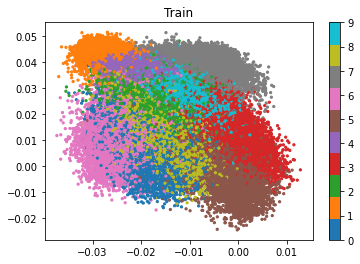

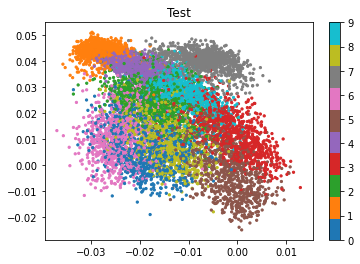

In [ ]:
# Plot

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

dataset_plot_train = datasets.MNIST(
    '~/mnist', 
    train=True, 
    download=True, 
    transform=transform)
dataset_plot_test  = datasets.MNIST(
    '~/mnist', 
    train=False, 
    download=True, 
    transform=transform)

dataloader_plot_train = utils.data.DataLoader(dataset_plot_train,
                                          batch_size=len(dataset_plot_train),
                                          shuffle=True,
                                          num_workers=4)
dataloader_plot_test  = utils.data.DataLoader(dataset_plot_test,
                                          batch_size=len(dataset_plot_test),
                                          shuffle=True,
                                          num_workers=4)

### Train ###
x, t = iter(dataloader_plot_train).next()
x = x.to(device)
y = model.forward_plot(x)
y = y.cpu().detach().numpy()

plt.scatter(y[:,0], y[:,1], c=t, s=5, cmap=cm.tab10)
plt.title("Train")
plt.colorbar()
plt.show()

### Test ###
x, t = iter(dataloader_plot_test).next()
x = x.to(device)
y = model.forward_plot(x)
y = y.cpu().detach().numpy()

plt.scatter(y[:,0], y[:,1], c=t, s=5, cmap=cm.tab10)
plt.title("Test")
plt.colorbar()
plt.show()

参考<br>
https://github.com/adambielski/siamese-triplet